## Upload Kaggle JSON

In [ ]:
# run perintah dibawah hanya untuk Google colab
from google.colab import drive # colab only
from google.colab import files # colab only

# Upload the *.json file to the colab, *.json file is for auth to kaggle 
# You need an auth *.json files from your kaggle account
# To download the files through the API
files.upload() 

# install some requirements for kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

# Source: https://www.kaggle.com/general/74235
from kaggle.api.kaggle_api_extended import KaggleApi

Saving kaggle.json to kaggle.json
kaggle.json


## Import all of needed library


In [ ]:
# run perintah dibawah hanya untuk Google colab
from google.colab import drive # colab only
from google.colab import files # colab only

In [ ]:
# buat ignore semua warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import requests
import random
import calendar
import time

from PIL import Image

from tqdm import tqdm

from shutil import move
from shutil import copy
from shutil import make_archive
from shutil import rmtree

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow import lite, cast, float32, saved_model, keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import Input, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.models import load_model
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils

from imblearn.over_sampling import RandomOverSampler 

In [ ]:
# To mounting Google Drive
def google_drive_mount(mounting=False):
    if mounting:
        drive.mount('/content/drive')


In [ ]:
class Dataset:

    def __init__(self):

        tmp = f'{os.getcwd()}/downloaded_dataset'

        if not os.path.exists(tmp):
            try:
                os.mkdir(tmp)
            except IOError as err:
                print(f'cannot access {tmp}: ', err)
        else:
            pass
        self.tmp = tmp


class KaggleDownloader(Dataset):

    def __init__(self):

        super().__init__()
        api = KaggleApi()
        self.__api = api

    def download_files(self, dataset, method, quiet=False):

        try:

            self.__api.authenticate()
            print('auth success')

            print(f'Downloading {dataset}.zip')

            if method == 'datasets':

                self.__api.dataset_download_files(
                    dataset=dataset,
                    path=self.tmp,
                    quiet=quiet)

                print(f'Download {dataset}.zip Successfully')

            elif method == 'competitions':

                self.__api.competition_download_files(
                    competition=dataset,
                    path=self.tmp,
                    quiet=quiet)

                print(f'Downloading {dataset}.zip Successfully')

            else:
                raise ValueError(f'{method} is not dataset nor competition')

        except ValueError as err:
            raise ValueError('Kaggle.json invalid: ', err)

        except OSError as err:
            raise OSError('Kaggle.json not found: ', err)

    def download_file(self, dataset, method, filename, quiet=False):

        try:

            self.__api.authenticate()
            print('auth success')

            print(f'Downloading {dataset}/{filename}')

            if method == 'datasets':

                self.__api.dataset_download_file(
                    dataset=dataset,
                    file_name=filename,
                    path=self.tmp,
                    quiet=quiet)

                print(f'Download {dataset}/{filename} Successfully')

            elif method == 'competitions':

                self.__api.competition_download_file(
                    competition=dataset,
                    file_name=filename,
                    path=self.tmp,
                    quiet=quiet)

                print(f'Downloading {dataset}/{filename} Successfully')

            else:
                raise ValueError(f'{method} is not dataset nor competition')

        except ValueError as err:
            raise ValueError('Kaggle.json invalid: ', err)

        except OSError as err:
            raise OSError('Kaggle.json not found: ', err)


class GoogleDriveDownloader(Dataset):

    def __init__(self, url):

        super().__init__()
        self.__url_raw = 'https://docs.google.com/uc?export=download'
        self.__chunk_size = 32768

        if 'view' not in url:
            self.__file_id = url.split('/')[-1]

        else:
            self.__file_id = url.split('/')[-2]

    def __get_confirm_token(self, response):

        for key, value in response.cookies.items():

            if key.startswith('download_warning'):
                return value

        return None

    def download_file(self, ext='.zip', namefile=time.strftime("%Y%m%d-%H%M%S")): # noqa

        print(f'Downloading {namefile}{ext} with id {self.__file_id}')

        try:

            session = requests.Session()
            response = session.get(self.__url_raw,
                                   params={'id': self.__file_id},
                                   stream=True,
                                   timeout=100)

            token = self.__get_confirm_token(response)

            if token:
                response = session.get(self.__url_raw,
                                       params={'id': self.__file_id,
                                               'confirm': token},
                                       stream=True,
                                       timeout=100)

            with open(f'{self.tmp}/{namefile}{ext}', 'wb') as file:
                for chunk in response.iter_content(self.__chunk_size):
                    if chunk:
                        try:
                            file.write(chunk)
                        except requests.exceptions.HTTPError as errh:
                            print("Http Error:", errh)
                        except requests.exceptions.ConnectionError as errc:
                            print("Error Connecting:", errc)
                        except requests.exceptions.Timeout as errt:
                            print("Timeout Error:", errt)
                        except requests.exceptions.RequestException as err:
                            print("OOps: Something Else", err)
                        except OSError as errd:
                            print("File cannot accessible", errd)

            print(f'Download {namefile}{ext} with id {self.__file_id} Successfully') # noqa

        except requests.exceptions.HTTPError as errh:
            print("Http Error:", errh)
        except requests.exceptions.ConnectionError as errc:
            print("Error Connecting:", errc)
        except requests.exceptions.Timeout as errt:
            print("Timeout Error:", errt)
        except requests.exceptions.RequestException as err:
            print("OOps: Something Else", err)

        return namefile


class webDownloader(Dataset):

    def __init__(self, url):

        super().__init__()
        self.__url = url
        self.__file_name = url.split("/")[-1]
        self.__chunk_size = 1024

    def download_file(self):

        print(f'Downloading {self.__file_name}')

        try:
            with requests.Session() as session:
                r = session.get(self.__url, stream=True, timeout=100)

            with open(f'{self.tmp}/{self.__file_name}', 'wb') as f:
                for chunk in response.iter_content(chunk_size=self.__chunk_size): # noqa
                    if chunk:
                        try:
                            f.write(chunk)
                        except requests.exceptions.HTTPError as errh:
                            print("Http Error:", errh)
                        except requests.exceptions.ConnectionError as errc:
                            print("Error Connecting:", errc)
                        except requests.exceptions.Timeout as errt:
                            print("Timeout Error:", errt)
                        except requests.exceptions.RequestException as err:
                            print("OOps: Something Else", err)
                        except OSError as err:
                            print("File cannot accessible", err)

            print(f'Download {self.__file_name} successfully')

        except requests.exceptions.HTTPError as errh:
            print("Http Error:", errh)
        except requests.exceptions.ConnectionError as errc:
            print("Error Connecting:", errc)
        except requests.exceptions.Timeout as errt:
            print("Timeout Error:", errt)
        except requests.exceptions.RequestException as err:
            print("OOps: Something Else", err)

        return self.__file_name


class Unpack(Dataset):

    def __init__(self, file):
        super().__init__()
        self.__file = file

    def unzip(self, ext=".zip", delete_after_unzip=False):

        if os.path.isfile(f'{self.tmp}/{self.__file}{ext}'):

            local_zip = f'{self.tmp}/{self.__file}{ext}'

            try:
                zip_ref = zipfile.ZipFile(local_zip, 'r')
                zip_ref.extractall(f'{self.tmp}/{self.__file}')
                print(f'Extract {self.__file}{ext} Successfully')

            except IOError as err:
                print(f'{self.tmp} is not accessible: ', err)

            finally:
                zip_ref.close()

            if delete_after_unzip:
                os.remove(f'{self.tmp}/{self.__file}{ext}')

        else:
            raise IOError(f"{self.__file}{ext} doesn't exists")


class Pack(Dataset):

    def __init__(self, file):
        super().__init__()
        self.__file = file

    def zip(self, ext=".zip", delete_folder_after_zip=False):

        ext = ext.replace(".", "")
        filepath = f'{self.tmp}/{self.__file}'

        if os.path.exists(filepath):

            try:
                make_archive(f"{self.tmp}/modified_{self.__file}",
                             ext,
                             filepath)
                print(f'Create modified_{self.__file}.{ext} Successfully')

            except IOError as err:
                print(f'{self.tmp} is not accessible: ', err)

            if delete_folder_after_zip:
                rmtree(filepath)

        else:
            raise IOError(f"{self.__file} doesn't exists")


In [ ]:
# Load the saved models/checkpoints models from Google Drive

def load_models(url, summary=False, filenames='tmp'):
  model_download = download_file(url, unzip=False, remove_after_unzip=True, google_drive=True, ext="h5", filename=filenames)  
  model = load_model(model_download)
  if summary:
    model.summary()
  return model


In [ ]:
class_names_short = ['AKIEC','BCC','BKL','DF','NV','MEL','VASC']
class_names = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']
class_names_long = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']

## Converting the datasets
Purpose for this section is to Converting the datasets into smaller and more memory friendly format
This section has already ran, so no need to run all of the cells again.

Resizing the datasets into small size and rearranging to make training more faster, <br>
Source datasets: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

In [ ]:
# Downloading the datasets using Kaggle API
data = 'kaggle datasets download -d kmader/skin-cancer-mnist-ham10000'
data = ' '.join([data]).split()
if data[1] == 'datasets':
    filename = (" ".join([data[4].replace("/", " ")]).split())[1]
else:
    filename = data[4]        
KaggleDownloader().download_files(dataset=data[4], method=data[1], quiet=False)    

auth success


100%|██████████| 5.20G/5.20G [01:40<00:00, 55.7MB/s]


Download kmader/skin-cancer-mnist-ham10000.zip Successfully


In [ ]:
Unpack(file=filename).unzip(delete_after_unzip=True)

In [ ]:
# Resizing and moving function
def resize_img(SOURCE, DEST, SIZE=150, remove_after_resize=False):
  
  files = []
  
  if not os.path.exists(DEST):
      os.mkdir(DEST)
  
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")
  
  print(f"{SOURCE}: {len(files)}")
  
  for filename in files:
    if '.jpg' in filename:
      img = cv2.imread(f"{SOURCE}{filename}")
      resize_img = cv2.resize(img, (SIZE,SIZE))
      cv2.imwrite(f"{SOURCE}/{filename}", resize_img)
      move(f"{SOURCE}/{filename}",f"{DEST}/{filename}")
  
  print(f"Succesfully moving {SOURCE} to {DEST}")
  
  print(f"After Moving {DEST}: {len(os.listdir(DEST))}\n") # Checking how much file in HAM10000 to make sure there is no file lost
  
  if remove_after_resize:
    rmtree(SOURCE)

In [ ]:
# Resizing the image
SRC = f'{Dataset().tmp}/{filename}'

if not os.path.exists(f"{SRC}/HAM10000"):
    try:
        os.mkdir(f"{SRC}/HAM10000")
    except:
        print('Error')

if os.path.exists(f"{SRC}/HAM10000"):
    try:
        resize_img(f'{SRC}/HAM10000_images_part_1/', f'{SRC}/HAM10000/', remove_after_resize=True)
        resize_img(f'{SRC}/HAM10000_images_part_2/', f'{SRC}/HAM10000/', remove_after_resize=True)
    except:
        print('Error')

/content/downloaded_dataset/skin-cancer-mnist-ham10000/HAM10000_images_part_1/: 5000
Succesfully moving /content/downloaded_dataset/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ to /content/downloaded_dataset/skin-cancer-mnist-ham10000/HAM10000/
After Moving /content/downloaded_dataset/skin-cancer-mnist-ham10000/HAM10000/: 5000

/content/downloaded_dataset/skin-cancer-mnist-ham10000/HAM10000_images_part_2/: 5015
Succesfully moving /content/downloaded_dataset/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ to /content/downloaded_dataset/skin-cancer-mnist-ham10000/HAM10000/
After Moving /content/downloaded_dataset/skin-cancer-mnist-ham10000/HAM10000/: 10015



In [ ]:
# Converting lesion type to more readable format
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Reading the csv file
df = pd.read_csv(f'{SRC}/HAM10000_metadata.csv')

# Adding more columns in csv
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

# Writing new metadata.csv
df.to_csv(f'{SRC}/metadata.csv')

# Then delete unnecessary files
rmtree(f'{SRC}/ham10000_images_part_1/')
rmtree(f'{SRC}/ham10000_images_part_2/')
os.remove(f'{SRC}/hmnist_28_28_L.csv')
os.remove(f'{SRC}/hmnist_28_28_RGB.csv')
os.remove(f'{SRC}/hmnist_8_8_L.csv')
os.remove(f'{SRC}/hmnist_8_8_RGB.csv')
os.remove(f'{SRC}/HAM10000_metadata.csv')

In [ ]:
df['cell_type'].value_counts()

Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: cell_type, dtype: int64

In [ ]:
Pack(file=filename).zip(delete_folder_after_zip=True)

Create modified_skin-cancer-mnist-ham10000.zip Successfully


In [ ]:
google_drive_mount(mounting=True)
if not os.path.exists(f"{os.getcwd()}/drive/MyDrive/tugas_akhir"):
    try:
        os.mkdir(f"{os.getcwd()}/drive/MyDrive/tugas_akhir")
    except Exception as err:
        print("Error: ", err)

if os.path.isfile(f"{Dataset().tmp}/modified_{filename}.zip"):
    try:
        move(f"{Dataset().tmp}/modified_{filename}.zip", f"{os.getcwd()}/drive/MyDrive/tugas_akhir")
        print(f"Moving {Dataset().tmp}/modified_{filename}.zip to {os.getcwd()}/drive/MyDrive/tugas_akhir success")
    except Exception as err:
        print("Error: ", err)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Moving /content/downloaded_dataset/modified_skin-cancer-mnist-ham10000.zip to /content/drive/MyDrive/tugas_akhir success


## Input data

In [ ]:
url = 'https://drive.google.com/file/d/1---2BwW769r8jYOBMrFtHQfWn-Kvm4CX/view?usp=sharing'
filename = 'modified_skin-cancer-mnist-ham10000'
GoogleDriveDownloader(url).download_file(namefile=filename)
Unpack(file=filename).unzip(delete_after_unzip=True)

# Checking the downloaded file
len(os.listdir(f'{Dataset().tmp}/{filename}/HAM10000'))

Download modified_skin-cancer-mnist-ham10000.zip with id 1---2BwW769r8jYOBMrFtHQfWn-Kvm4CX Successfully
Extract modified_skin-cancer-mnist-ham10000.zip Successfully


10015

In [ ]:
def define_dataset(csv, unique=False, show_df = False):

  df = pd.read_csv(csv) # Reading the csv files from pandas
  img = df['image_id'] # Define the Feature 
  target = df['cell_type_idx'].values # Define the Labels
  df_unique = df['cell_type'].value_counts() # Amout of unique value

  if unique: # Counting unique values
    return img, target, df_unique
  
  if show_df:
    return img, target, df, df_unique
  
  else:
    return img, target

In [ ]:
# Defining dataset into labels and features
img, target, df, df_unique = define_dataset(f'{Dataset().tmp}/{filename}/metadata.csv', show_df=True)

## Visualizing the data

### Tabel Dataset

In [ ]:
df = df.drop(columns=['Unnamed: 0'], axis=1)
df = df.drop(df[df['sex'] == 'unknown'].index)
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,Actinic keratoses,0


### Visualiasi Gambar Dataset

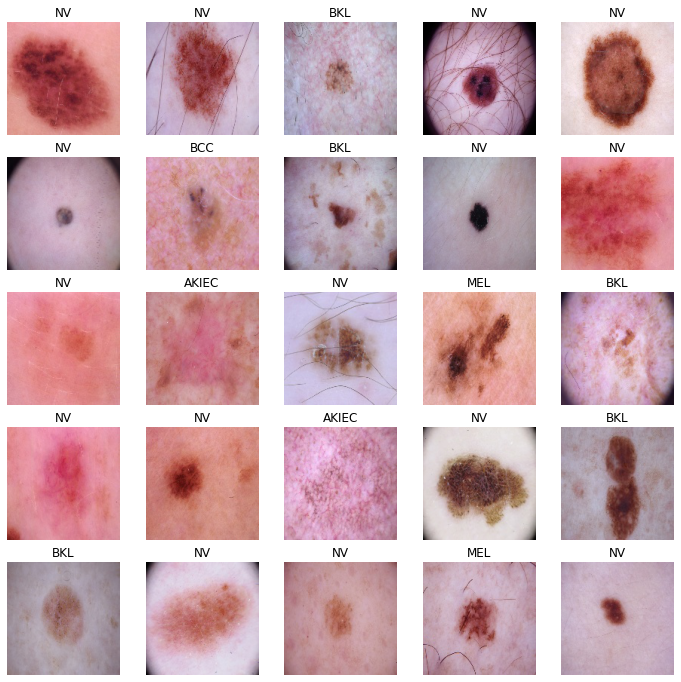

In [ ]:
def show_batch(x, y, figsize=12, subfigsize=5, n=25, no_axis=True):

    test_df = pd.DataFrame({
        'image': x,
        'label': y
    })
    test_df = test_df.sample(n)
    test_df.reset_index(inplace=True)
    test_df

    plt.figure(figsize=(figsize, figsize)) # Defining figure of the datasets
  
    for i in range(n): # Iterating through n datasets randomly
        ax = plt.subplot(subfigsize, subfigsize, i+1) # Defining frontend of figure
        cp_imgs = load_img(f"{Dataset().tmp}/{filename}/HAM10000/{test_df['image'][i]}.jpg", target_size=(150, 150)) # Showing the picture from datasets
        cp_imgs = img_to_array(cp_imgs)
        cp_imgs = cp_imgs.astype(np.float32)/255
        plt.imshow(cp_imgs)
        plt.title(class_names_short[test_df['label'][i]]) # Showing class names

        # Remove axis from the figure
        if no_axis:
            plt.axis('off')

# Showing images from the datasets
show_batch(img, target)

### Visualisasi Jenis Kanker Kulit

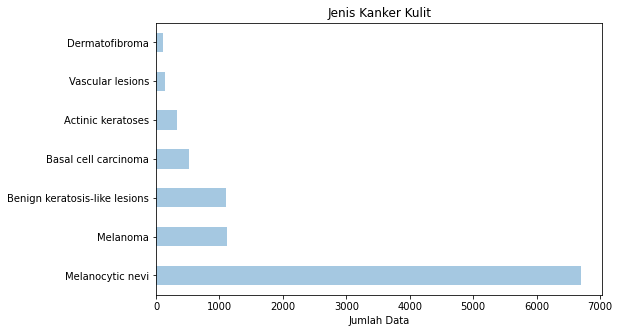

In [ ]:
plt.figure(figsize=(8,5))
df_unique.plot(kind='barh', color='#A5C8E1')
plt.title(f'Jenis Kanker Kulit')
plt.xlabel("Jumlah Data")
plt.show()

### Visualisasi Pesebaran Pasien Kanker Kulit Berdasarkan Umur

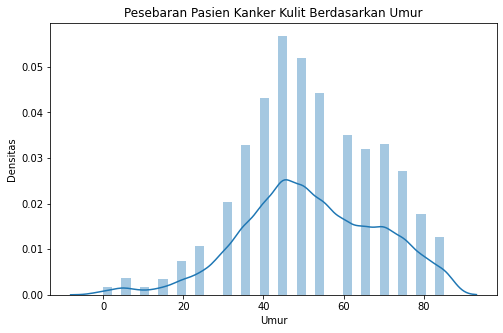

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(df['age'])
plt.title(f'Pesebaran Pasien Kanker Kulit Berdasarkan Umur')
plt.ylabel("Densitas")
_ = plt.xlabel("Umur")
plt.show()

### Visualisasi Pesebaran Pasien Kanker Kulit Berdasarkan Lokasi Kanker Kulit

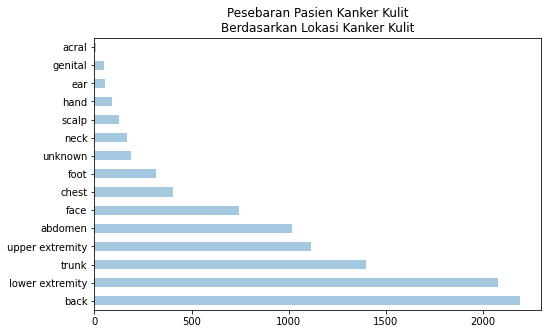

In [ ]:
plt.figure(figsize=(8,5))
plt.title(f'Pesebaran Pasien Kanker Kulit\nBerdasarkan Lokasi Kanker Kulit')
df['localization'].value_counts().plot(kind='barh', color='#A5C8E1')
plt.show()

### Visualisasi Pesebaran Pasien Kanker Kulit Berdasarkan Gender

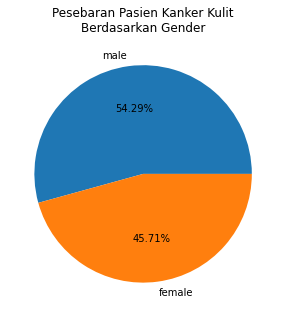

In [ ]:
plt.figure(figsize=(8,5))
plt.title(f'Pesebaran Pasien Kanker Kulit\nBerdasarkan Gender')
plt.pie(df['sex'].value_counts(), labels=df['sex'].value_counts().index, autopct='%0.2f%%')
plt.show()

### Visualisasi Pesebaran Pasien Kanker Kulit Berdasarkan Umur dan Gender

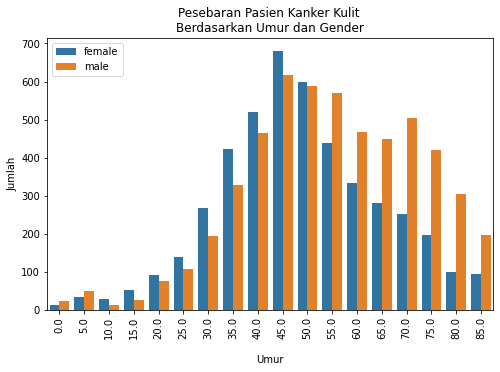

In [ ]:
df_coba1 = df[['age', 'sex']].value_counts().to_frame()
df_coba1.reset_index(level=[1,0 ], inplace=True)
df_temp1 = df_coba1.rename(columns = {0: 'count'})
df_temp1

plt.figure(figsize=(8,5))
sns.barplot(x = 'age',  y='count', hue = 'sex', data = df_temp1)
plt.title('Pesebaran Pasien Kanker Kulit \nBerdasarkan Umur dan Gender')
plt.xlabel('\nUmur')
plt.ylabel('Jumlah')
plt.xticks(rotation = 90)
plt.legend(loc='upper left')
plt.show()

### Visualisasi Pesebaran Pasien Kanker Kulit Berdasarkan Umur dan Jenis Kanker

Karena Nevi merupakan jenis kanker yang paling banyak, maka kita akan drop Nevi (akan dibuat visualisasi sendiri) supaya visualisasi bisa dilihat lebih rapih

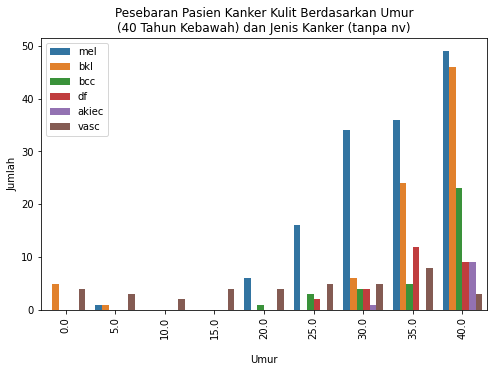

In [ ]:
df_coba2 = df[['age', 'dx']].value_counts().to_frame()
df_coba2.reset_index(level=[1,0 ], inplace=True)
df_temp2 = df_coba2.rename(columns = {0: 'count'})
df_temp2 = df_temp2[df_temp2['age'] <= 40]
df_temp2 = df_temp2[df_temp2['dx'] != 'nv']

plt.figure(figsize=(8,5))
sns.barplot(x = 'age',  y='count', hue = 'dx', data = df_temp2)
plt.title('Pesebaran Pasien Kanker Kulit Berdasarkan Umur\n(40 Tahun Kebawah) dan Jenis Kanker (tanpa nv)')
plt.xlabel('\nUmur')
plt.ylabel('Jumlah')
plt.xticks(rotation = 90)
plt.legend(loc='upper left')
plt.show()

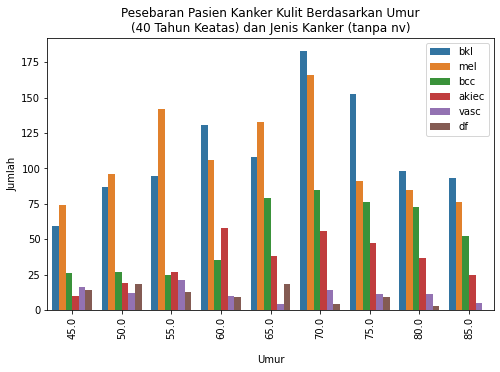

In [ ]:
df_coba3 = df[['age', 'dx']].value_counts().to_frame()
df_coba3.reset_index(level=[1,0 ], inplace=True)
df_temp3 = df_coba3.rename(columns = {0: 'count'})
df_temp3 = df_temp3[df_temp3['age'] > 40]
df_temp3 = df_temp3[df_temp3['dx'] != 'nv']

plt.figure(figsize=(8,5))
sns.barplot(x = 'age',  y='count', hue = 'dx', data = df_temp3)
plt.title('Pesebaran Pasien Kanker Kulit Berdasarkan Umur\n(40 Tahun Keatas) dan Jenis Kanker (tanpa nv)')
plt.xlabel('\nUmur')
plt.ylabel('Jumlah')
plt.xticks(rotation = 90)
plt.legend(loc='upper right')
plt.show()

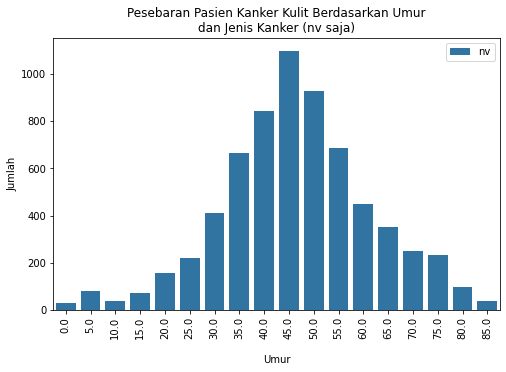

In [ ]:
df_coba4 = df[['age', 'dx']].value_counts().to_frame()
df_coba4.reset_index(level=[1,0 ], inplace=True)
df_temp4 = df_coba4.rename(columns = {0: 'count'})
df_temp4 = df_temp4[df_temp4['dx'] == 'nv']

plt.figure(figsize=(8,5))
sns.barplot(x = 'age',  y='count', hue = 'dx', data = df_temp4)
plt.title('Pesebaran Pasien Kanker Kulit Berdasarkan Umur\ndan Jenis Kanker (nv saja)')
plt.xlabel('\nUmur')
plt.ylabel('Jumlah')
plt.xticks(rotation = 90)
plt.legend(loc='upper right')
plt.show()

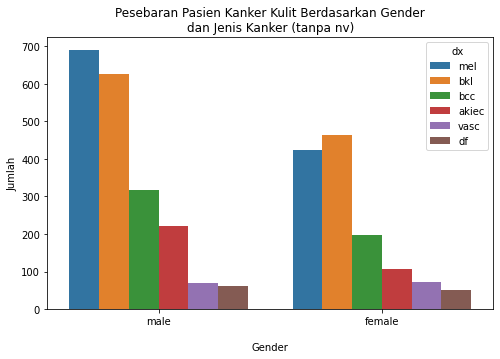

In [ ]:
df_coba5 = df[['dx', 'sex']].value_counts().to_frame()
df_coba5.reset_index(level=[1,0 ], inplace=True)
df_temp5 = df_coba5.rename(columns = {0: 'count'})
df_temp5 = df_temp5[df_temp5['dx'] != 'nv']

plt.figure(figsize=(8,5))
sns.barplot(x = 'sex',  y='count', hue = 'dx', data = df_temp5)
plt.title(f'Pesebaran Pasien Kanker Kulit Berdasarkan Gender\ndan Jenis Kanker (tanpa nv)')
plt.xlabel('\nGender')
plt.ylabel('Jumlah')
plt.show()

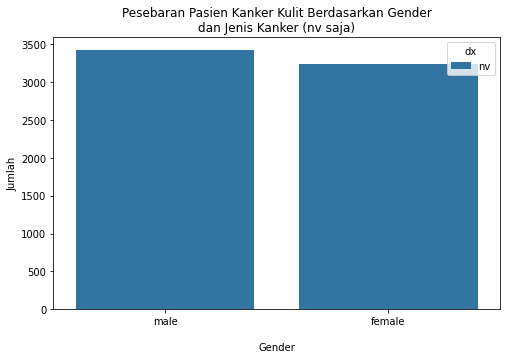

In [ ]:
df_coba6 = df[['dx', 'sex']].value_counts().to_frame()
df_coba6.reset_index(level=[1,0 ], inplace=True)
df_temp6 = df_coba6.rename(columns = {0: 'count'})
df_temp6 = df_temp6[df_temp6['dx'] == 'nv']

plt.figure(figsize=(8,5))
sns.barplot(x = 'sex',  y='count', hue = 'dx', data = df_temp6)
plt.title(f'Pesebaran Pasien Kanker Kulit Berdasarkan Gender\ndan Jenis Kanker (nv saja)')
plt.xlabel('\nGender')
plt.ylabel('Jumlah')
plt.show()

### Visualisasi Pesebaran Pasien Kanker Kulit Berdasarkan Umur dan Lokasi Kanker

In [ ]:
def umur_lokasi(df, n, lists, loc='upper right'):
    df_coba4 = df[['age', 'localization']].value_counts().to_frame()
    df_coba4.reset_index(level=[1,0 ], inplace=True)
    df_temp4 = df_coba4.rename(columns = {0: 'count'})
    df_temp4 = df_temp4[df_temp4['localization'].isin(lists)]

    plt.figure(figsize=(8,5))
    sns.barplot(x = 'age',  y='count', hue = 'localization', data = df_temp4)
    plt.title(f'Pesebaran Pasien Kanker Kulit \nBerdasarkan Umur dan Lokasi Kanker {n}')
    plt.xlabel('\nUmur')
    plt.ylabel('Jumlah')
    plt.legend(loc=loc)
    plt.xticks(rotation = 90)
    plt.show()

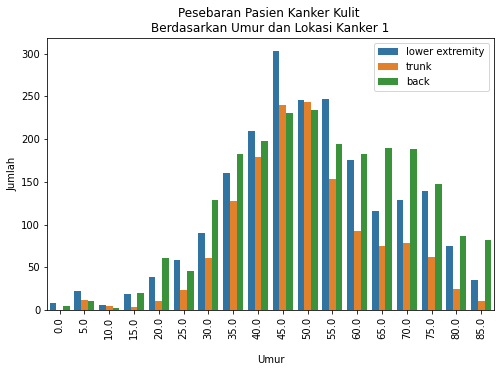

In [ ]:
umur_lokasi(df, n = 1, lists = df['localization'].value_counts().index.to_list()[:3])

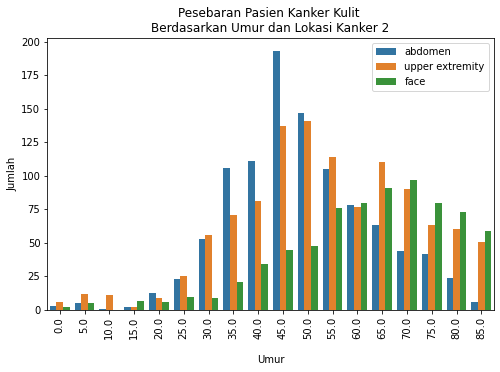

In [ ]:
umur_lokasi(df, n = 2, lists = df['localization'].value_counts().index.to_list()[3:6])

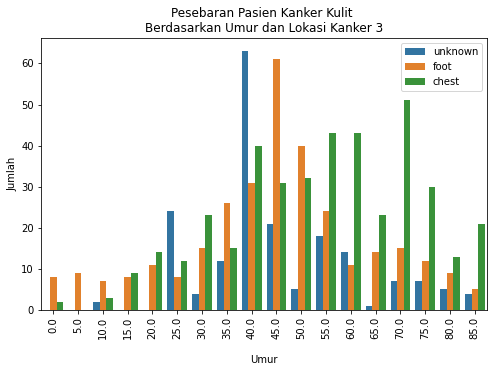

In [ ]:
umur_lokasi(df, n = 3, lists = df['localization'].value_counts().index.to_list()[6:9])

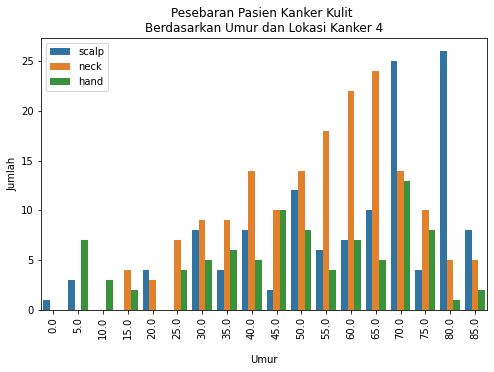

In [ ]:
umur_lokasi(df, n = 4, loc='upper left', lists = df['localization'].value_counts().index.to_list()[9:12])

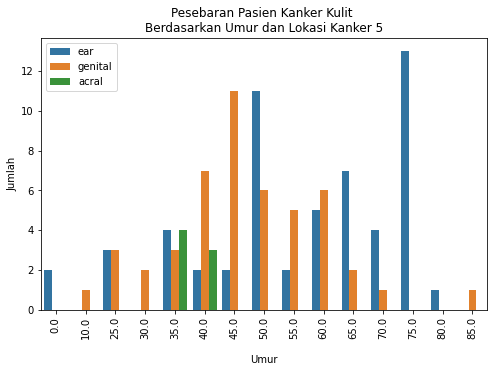

In [ ]:
umur_lokasi(df, n = 5, loc='upper left', lists = df['localization'].value_counts().index.to_list()[12:15])

### Visualisasi Pesebaran Pasien Kanker Kulit Berdasarkan Gender dan Lokasi Kanker

In [ ]:
def gender_lokasi(df, n, lists, loc='upper right'):
    df_coba5 = df[['sex', 'localization']].value_counts().to_frame()
    df_coba5.reset_index(level=[1,0 ], inplace=True)
    df_temp5 = df_coba5.rename(columns = {0: 'count'})
    df_temp5 = df_temp5[df_temp5['localization'].isin(lists)]

    plt.figure(figsize=(8,5))
    sns.barplot(x = 'sex',  y='count', hue = 'localization', data = df_temp5)
    plt.title(f'Pesebaran Pasien Kanker Kulit \nBerdasarkan Gender dan Lokasi Kanker {n}')
    plt.xlabel('\nGender')
    plt.ylabel('Jumlah')
    plt.legend(loc=loc)
    plt.show()

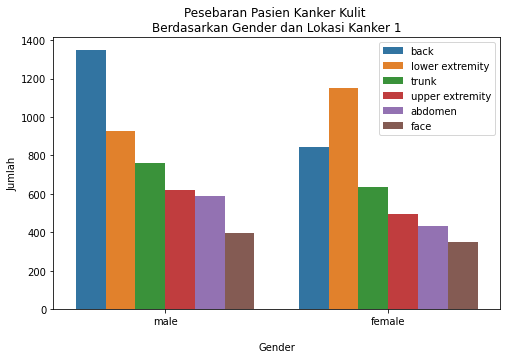

In [ ]:
gender_lokasi(df, n = 1, lists = df['localization'].value_counts().index.to_list()[:6])

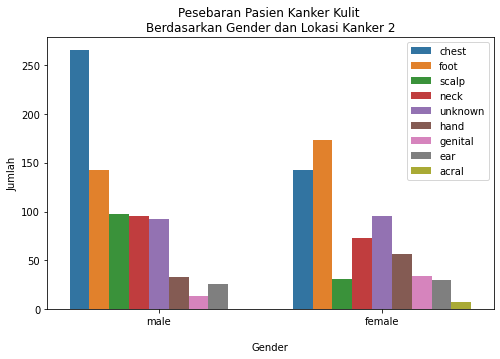

In [ ]:
gender_lokasi(df, n = 2, lists = df['localization'].value_counts().index.to_list()[6:])

### Visualisasi Pesebaran Pasien Kanker Kulit Berdasarkan Lokasi dan Jenis Kanker

Karena Nevi merupakan jenis kanker yang paling banyak, maka kita akan drop Nevi (akan dibuat visualisasi sendiri) supaya visualisasi bisa dilihat lebih rapih

In [ ]:
def lokasi_jenis(df, n, lists, nv_only = False, loc = 'upper right'):
    df_coba7 = df[['dx', 'localization']].value_counts().to_frame()
    df_coba7.reset_index(level=[1,0 ], inplace=True)
    df_temp7 = df_coba7.rename(columns = {0: 'count'})
    df_temp7 = df_temp7[df_temp7['localization'].isin(lists)]

    if nv_only:
        df_temp7 = df_temp7[df_temp7['dx'] == 'nv']

        plt.figure(figsize=(8,5))
        sns.barplot(x = 'localization',  y='count', hue = 'dx', data = df_temp7)
        plt.title(f'Pesebaran Pasien Kanker Kulit Berdasarkan Lokasi\ndan Jenis Kanker (nv saja) {n}')
        plt.xlabel('\nLokasi')
        plt.ylabel('Jumlah')
        plt.legend(loc=loc)
        plt.show()

    else:
        df_temp7 = df_temp7[df_temp7['dx'] != 'nv']

        plt.figure(figsize=(8,5))
        sns.barplot(x = 'localization',  y='count', hue = 'dx', data = df_temp7)
        plt.title(f'Pesebaran Pasien Kanker Kulit Berdasarkan Lokasi\ndan Jenis Kanker (tanpa nv) {n}')
        plt.xlabel('\nLokasi')
        plt.ylabel('Jumlah')
        plt.legend(loc=loc)
        plt.show()

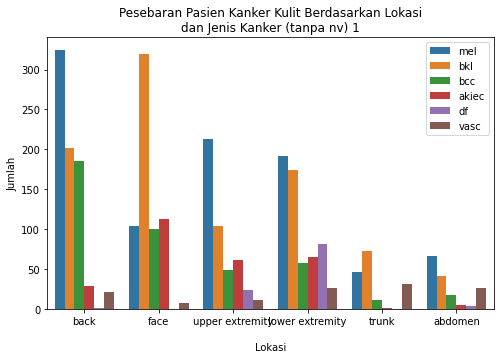

In [ ]:
lokasi_jenis(df, n=1, lists = df['localization'].value_counts().index.to_list()[:6], nv_only = False, loc = 'upper right')

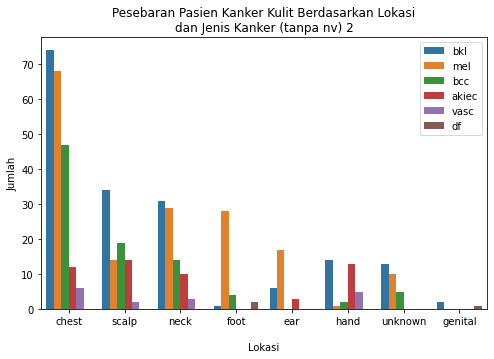

In [ ]:
lokasi_jenis(df, n=2, lists = df['localization'].value_counts().index.to_list()[6:], nv_only = False, loc = 'upper right')

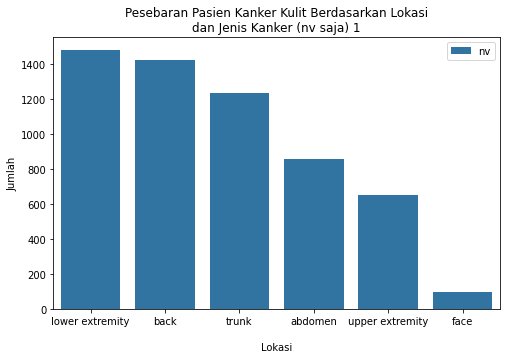

In [ ]:
lokasi_jenis(df, n=1, lists = df['localization'].value_counts().index.to_list()[:6], nv_only = True, loc = 'upper right')

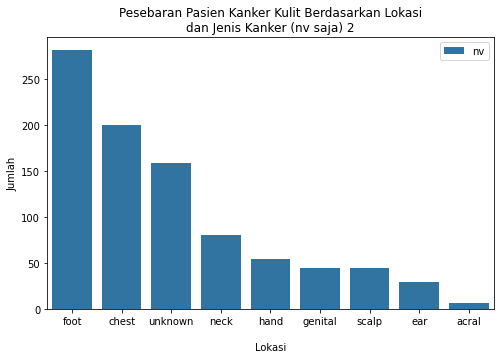

In [ ]:
lokasi_jenis(df, n=2, lists = df['localization'].value_counts().index.to_list()[6:], nv_only = True, loc = 'upper right')

## Train the data

In [ ]:
def split_data(x, y, 
               test_size=0.2, 
               validation_size=0.05, 
               balancing=False,
               random_state=1234):
  
  # Balancing the datasets, if the datasets not balanced so this function will balanced them
  def balancing_dataset(x_train, x_val, y_train, y_val):
    
    # Balancing with OverSampler method from Imbalanced Learn
    # Source: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
    oversample = RandomOverSampler()
    x_train, y_train  = oversample.fit_resample(x_train.values.reshape(-1,1),y_train)
    x_val, y_val  = oversample.fit_resample(x_val.values.reshape(-1,1),y_val)
    
    return x_train, x_val, y_train, y_val
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_size, random_state=random_state)

  # If balancing is True, so the datasets will be balancing
  if balancing:
    x_train, x_val, y_train, y_val = balancing_dataset(x_train, x_val, y_train, y_val)
  
  # Print the results of splitting
  print("Train: ", x_train.shape[0]), print("Val: ", x_val.shape[0]), print("Test: ", x_test.shape[0]), 
  
  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
# Splitting into train, valid and test with balancing all of the data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(img, target, balancing=False, test_size=0.2, validation_size=0.2)

Train:  8012
Val:  2003
Test:  2003


In [ ]:
def to_tensor(image_paths,
              oversample=True,
              size=64):
 
    imgs = []
  
    for i in tqdm(image_paths):
        if oversample: # If datasets is balanced
            img = load_img(f"{Dataset().tmp}/{filename}/HAM10000/{i[0]}.jpg", target_size=(size, size)) # Load the Image then resized them
        else:
            img = load_img(f"{Dataset().tmp}/{filename}/HAM10000/{i}.jpg", target_size=(size, size)) # Load the Image then resized them
            img = img_to_array(img) # Convert the Image to arrays
            img = img.astype(np.float32) / 255 # Rescale the Images
        imgs.append(img) # Load all of Images to datasets
    return np.stack(imgs, axis=0) # Join a sequence of arrays along a new axis in other hands, transpose the axis

In [ ]:
# We only balanced the Train and Validation data
# So, if we set oversample to True for x_test
# There will be errors
#x_train = to_tensor(x_train, size=150)
#x_val = to_tensor(x_val, size=150)
# x_test = to_tensor(x_test)

# Unbalanced datasets
x_train = to_tensor(x_train, oversample=False, size=150)
x_val = to_tensor(x_val, oversample=False, size=150)
x_test = to_tensor(x_test, oversample=False, size=150) # Since this is only the test dataset, no need to balanced this

100%|██████████| 2003/2003 [00:02<00:00, 1001.46it/s]


In [ ]:
X = to_tensor(img, oversample=False, size=150)

100%|██████████| 10015/10015 [00:11<00:00, 890.21it/s]


In [ ]:
y = target

In [ ]:
print(y_train.shape)
print(x_train.shape)

(8012,)
(8012, 150, 150, 3)


In [ ]:
print(y.shape)
print(X.shape)

(10015,)
(10015, 150, 150, 3)


## Defining the models and training the datasets
Defining the models and train the datasets based from the models that have been adjusted

In [ ]:
# Scoring saved models/checkpoint models

def scoring(model, x_test, y_test, class_names):

    def plot_confusionmat(confusion_mat, class_names, cmap='GnBu'):
  
        fig, ax = plt.subplots(figsize=(10,10))
  
        sns.heatmap(confusion_mat, annot=True, fmt='.2f',
                xticklabels=[f"{c}" for c in class_names], 
                yticklabels=[f"{c}" for c in class_names],
                cmap=cmap)
  
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show() 
  
    score = model.evaluate(x_test, y_test, verbose=0)
    predicting = model.predict(x_test)
    pred = np.argmax(predicting, axis=1)
    report = classification_report(y_true=y_test, y_pred=pred, target_names=class_names)
    conf = confusion_matrix(y_test, pred) 

    plot_confusionmat(conf, class_names)
    print("\n%s: %.2f%%\n" % (model.metrics_names[1], score[1]*100))
    print("\nAccuracy: {0:.2f}%\n".format(accuracy_score(y_test, pred)*100))
    print(report)

    return pred, predicting
    

In [ ]:
# Defining the models

def trainable_model(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, 
                    fine_tuning=False, dropout=0.25, base_model='MobileNet', 
                    regularizer=0.01, learning_rate=1e-4, epochs=15, verbose=1, 
                    metrics='accuracy', pool_size=2, rotation_range=30, 
                    zoom_range=0.15, width_shift_range=0.2, shear_range=0.15, 
                    horizontal_flip=True, fill_mode="nearest", height_shift_range=0.2,
                    weights="imagenet", include_top=False, summary=False, 
                    valid_generator=False, generator=True, activation='relu',
                    activation_final='softmax', more_layer=True):
  
  dataset = (x_train, 
             y_train, 
             x_val, 
             y_val)

  BATCH_SIZE = batch_size
  INPUT_SHAPE = dataset[0][0].shape
  trainX = dataset[0]
  trainY = dataset[1]
  valX = dataset[2]
  valY = dataset[3]

  generators = ImageDataGenerator()
  
  train_dataset = generators.flow(trainX, 
                                  trainY, 
                                  batch_size=BATCH_SIZE)
  
  valid_dataset = generators.flow(valX, 
                                  valY, 
                                  batch_size=BATCH_SIZE)

  if generator:
    train_gen = ImageDataGenerator(rotation_range=rotation_range,
                                   zoom_range=zoom_range,
                                   width_shift_range=width_shift_range,
                                   height_shift_range=height_shift_range,
                                   shear_range=shear_range,
                                   horizontal_flip=horizontal_flip,
                                   fill_mode=fill_mode)

    train_dataset = train_gen.flow(trainX,
                                   trainY,
                                   batch_size=BATCH_SIZE)
    
    if valid_generator:
      valid_dataset = train_gen.flow(valX,
                                     valY,
                                     batch_size=BATCH_SIZE)
  
  if base_model in ['MobileNet','MobileNetV1']:
    base_model = MobileNet(weights=weights, 
                           include_top=include_top, 
                           input_tensor=Input(shape=INPUT_SHAPE)) # MobileNet: 83%, Epochs: 7

  elif base_model is 'MobileNetV2':
    base_model = MobileNetV2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # MobileNetV2: 75%, Epochs: 8

  elif base_model is 'VGG16':
    base_model = VGG16(weights=weights, 
                       include_top=include_top, 
                       input_tensor=Input(shape=INPUT_SHAPE)) # VGG16: 90%, Epochs: 7
  
  elif base_model in ['EfficientNetB0','EfficientNet']:
    base_model = EfficientNetB0(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # EfficientNetB0: 66%, Epochs: 6

  elif base_model is 'InceptionV3':
    base_model = InceptionV3(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Doesn't support by this dataset

  elif base_model is 'VGG19':
     base_model = VGG19(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # VGG19, 83%, Epochs: 10

  elif base_model is 'Xception':
    base_model = Xception(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Xception: 95%, Epochs: 9     

  elif base_model is 'DenseNet121':
    base_model = DenseNet121(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) 

  elif base_model is 'DenseNet201':
    base_model = DenseNet201(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # DenseNet201: 82% Epochs: 6

  elif base_model is 'ResNet152V2':
    base_model = ResNet152V2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # ResNet152V2: 75%, Epochs: 6

  elif base_model is 'EfficientNetB5':
    base_model = EfficientNetB5(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this

  elif base_model is 'ResNet50':
    base_model = ResNet50(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this
  else:
      raise ValueError(f"base_model is {base_model} which is not compatible for this model")

  base_model.trainable=False

  if fine_tuning:
    base_model.trainable=True
  
  model = Sequential([base_model])
  
  if more_layer:
    model = Sequential([base_model,
                        AveragePooling2D(pool_size=(pool_size ,pool_size)),      
                        Flatten(), 
                        Dense(64, activation=activation),
                        Dropout(dropout), 
                        Dense(16, activation=activation),
                        Dense(7, activation=activation_final, kernel_regularizer=l2(regularizer))])

  model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss=SparseCategoricalCrossentropy(), 
                metrics=[metrics])

  if summary:
    model.summary()

  history = model.fit(train_dataset, 
                      epochs=epochs, 
                      validation_data=valid_dataset, 
                      verbose=verbose)
  
  return history, model


In [ ]:
base_model = 'Xception'

#callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

#checkpoints = ModelCheckpoint(f'model with {base_model}' + "{accuracy:.2f}.h5", verbose=1, save_best_only=True)

history, model = trainable_model(x_train, y_train, x_val, y_val, x_test, y_test,
                                 fine_tuning=True, epochs=10, base_model=base_model, 
                                 dropout=0.2, regularizer=0.01, batch_size=32,
                                 summary=True) #callbacks=callbacks) #checkpoint=checkpoints)


NameError: ignored

In [ ]:
# Defining the models

def trainable_model(X,y , batch_size=64, 
                    fine_tuning=False, dropout=0.25, base_model='MobileNet', 
                    regularizer=0.01, learning_rate=1e-4, epochs=15, verbose=1, 
                    metrics='accuracy', pool_size=2, rotation_range=30, 
                    zoom_range=0.15, width_shift_range=0.2, shear_range=0.15, 
                    horizontal_flip=True, fill_mode="nearest", height_shift_range=0.2,
                    weights="imagenet", include_top=False, summary=False, 
                    valid_generator=False, generator=True, activation='relu',
                    activation_final='softmax', more_layer=True):
  
  dataset = (X,y)

  BATCH_SIZE = batch_size
  INPUT_SHAPE = dataset[0][0].shape
  trainX = dataset[0]
  trainY = dataset[1]

  generators = ImageDataGenerator()
  
  train_dataset = generators.flow(trainX, 
                                  trainY, 
                                  batch_size=BATCH_SIZE)
  

  if generator:
    train_gen = ImageDataGenerator(rotation_range=rotation_range,
                                   zoom_range=zoom_range,
                                   width_shift_range=width_shift_range,
                                   height_shift_range=height_shift_range,
                                   shear_range=shear_range,
                                   horizontal_flip=horizontal_flip,
                                   fill_mode=fill_mode)

    train_dataset = train_gen.flow(trainX,
                                   trainY,
                                   batch_size=BATCH_SIZE)
  
  if base_model in ['MobileNet','MobileNetV1']:
    base_model = MobileNet(weights=weights, 
                           include_top=include_top, 
                           input_tensor=Input(shape=INPUT_SHAPE)) # MobileNet: 83%, Epochs: 7

  elif base_model is 'MobileNetV2':
    base_model = MobileNetV2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # MobileNetV2: 75%, Epochs: 8

  elif base_model is 'VGG16':
    base_model = VGG16(weights=weights, 
                       include_top=include_top, 
                       input_tensor=Input(shape=INPUT_SHAPE)) # VGG16: 90%, Epochs: 7
  
  elif base_model in ['EfficientNetB0','EfficientNet']:
    base_model = EfficientNetB0(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # EfficientNetB0: 66%, Epochs: 6

  elif base_model is 'InceptionV3':
    base_model = InceptionV3(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Doesn't support by this dataset

  elif base_model is 'VGG19':
     base_model = VGG19(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # VGG19, 83%, Epochs: 10

  elif base_model is 'Xception':
    base_model = Xception(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Xception: 95%, Epochs: 9     

  elif base_model is 'DenseNet121':
    base_model = DenseNet121(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) 

  elif base_model is 'DenseNet201':
    base_model = DenseNet201(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # DenseNet201: 82% Epochs: 6

  elif base_model is 'ResNet152V2':
    base_model = ResNet152V2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # ResNet152V2: 75%, Epochs: 6

  elif base_model is 'EfficientNetB5':
    base_model = EfficientNetB5(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this

  elif base_model is 'ResNet50':
    base_model = ResNet50(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this
  else:
      raise ValueError(f"base_model is {base_model} which is not compatible for this model")

  base_model.trainable=False

  if fine_tuning:
    base_model.trainable=True
  
  model = Sequential([base_model])
  
  if more_layer:
    model = Sequential([base_model,
                        AveragePooling2D(pool_size=(pool_size ,pool_size)),      
                        Flatten(), 
                        Dense(64, activation=activation),
                        Dropout(dropout), 
                        Dense(16, activation=activation),
                        Dense(7, activation=activation_final, kernel_regularizer=l2(regularizer))])

  model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss=SparseCategoricalCrossentropy(), 
                metrics=[metrics])

  if summary:
    model.summary()

  history = model.fit(train_dataset, 
                      epochs=epochs, 
                      verbose=verbose)
  
  return history, model


In [ ]:
base_model = 'Xception'

#callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

#checkpoints = ModelCheckpoint(f'model with {base_model}' + "{accuracy:.2f}.h5", verbose=1, save_best_only=True)

history, model = trainable_model(X,y,
                                 fine_tuning=True, epochs=10, base_model=base_model, 
                                 dropout=0.2, regularizer=0.01, batch_size=32,
                                 summary=True) #callbacks=callbacks) #checkpoint=checkpoints)


83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
average_pooling2d (AveragePo (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_______________________________________________________

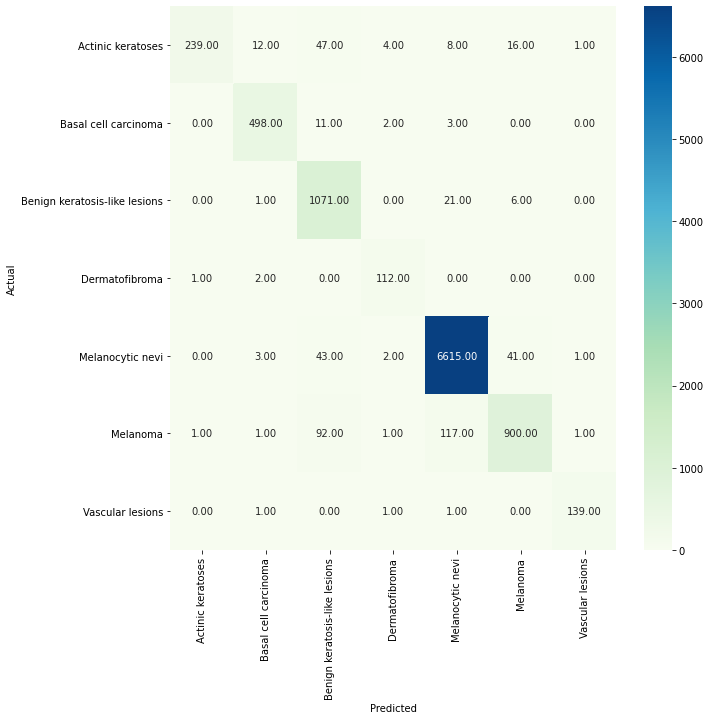


accuracy: 95.60%


Accuracy: 95.60%

                               precision    recall  f1-score   support

            Actinic keratoses       0.99      0.73      0.84       327
         Basal cell carcinoma       0.96      0.97      0.97       514
Benign keratosis-like lesions       0.85      0.97      0.91      1099
               Dermatofibroma       0.92      0.97      0.95       115
             Melanocytic nevi       0.98      0.99      0.98      6705
                     Melanoma       0.93      0.81      0.87      1113
             Vascular lesions       0.98      0.98      0.98       142

                     accuracy                           0.96     10015
                    macro avg       0.94      0.92      0.93     10015
                 weighted avg       0.96      0.96      0.96     10015



In [ ]:
pred, predicting = scoring(model, X, y, class_names)

In [ ]:
from keras.utils.np_utils import to_categorical
categorical_y_test = to_categorical(y, num_classes=7)

In [ ]:
categorical_y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_precision, lr_recall, _ = precision_recall_curve(y_test, pred)
lr_f1, lr_auc = f1_score(y_test, pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ValueError: ignored

Actinic keratoses: auc=96.95%
Basal cell carcinoma: auc=99.46%
Benign keratosis-like lesions: auc=98.37%
Dermatofibroma: auc=99.50%
Melanocytic nevi: auc=99.88%
Melanoma: auc=95.53%
Vascular lesions: auc=99.10%


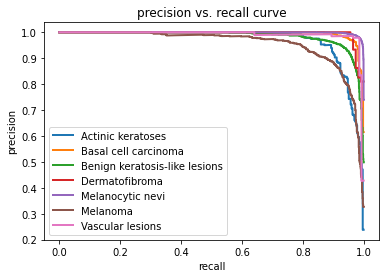

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
# precision recall curve
precision = dict()
recall = dict()
n_classes=7
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(categorical_y_test[:,i], predicting[:,i])
    #lr_f1, lr_auc = f1_score(categorical_y_test[:,i], predicting[:,i]), auc(recall[i], precision[i])
    lr_auc = auc(recall[i], precision[i])
    #print(f'{class_names[i]}: Logistic: f1={lr_f1:.3f} auc={lr_auc:.3f}')
    print(f'{class_names[i]}: auc={lr_auc*100:.2f}%')
    plt.plot(recall[i], precision[i], lw=2, label=class_names[i])
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

# Bla

In [ ]:
# Defining the models

def define_model(x_train, y_train, x_val, y_val, x_test, y_test, fine_tuning=True, 
                base_model='MobileNet', regularizer=0.01, learning_rate=1e-4, 
                metrics='accuracy', pool_size=2, weights="imagenet", dropout=0.25,
                include_top=False, activation='relu', activation_final='softmax',
                more_layer=True):
  
  dataset = (x_train, 
             y_train, 
             x_val, 
             y_val)

  INPUT_SHAPE = dataset[0][0].shape
  
  if base_model in ['MobileNet','MobileNetV1']:
    base_model = MobileNet(weights=weights, 
                           include_top=include_top, 
                           input_tensor=Input(shape=INPUT_SHAPE)) # MobileNet: 83%, Epochs: 7

  elif base_model is 'MobileNetV2':
    base_model = MobileNetV2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # MobileNetV2: 75%, Epochs: 8

  elif base_model is 'VGG16':
    base_model = VGG16(weights=weights, 
                       include_top=include_top, 
                       input_tensor=Input(shape=INPUT_SHAPE)) # VGG16: 90%, Epochs: 7
  
  elif base_model in ['EfficientNetB0','EfficientNet']:
    base_model = EfficientNetB0(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # EfficientNetB0: 66%, Epochs: 6

  elif base_model is 'InceptionV3':
    base_model = InceptionV3(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Doesn't support by this dataset

  elif base_model is 'VGG19':
     base_model = VGG19(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # VGG19, 83%, Epochs: 10

  elif base_model is 'Xception':
    base_model = Xception(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # Xception: 95%, Epochs: 9     

  elif base_model is 'DenseNet121':
    base_model = DenseNet121(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) 

  elif base_model is 'DenseNet201':
    base_model = DenseNet201(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # DenseNet201: 82% Epochs: 6

  elif base_model is 'ResNet152V2':
    base_model = ResNet152V2(weights=weights, 
                             include_top=include_top, 
                             input_tensor=Input(shape=INPUT_SHAPE)) # ResNet152V2: 75%, Epochs: 6

  elif base_model is 'EfficientNetB5':
    base_model = EfficientNetB5(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this

  elif base_model is 'ResNet50':
    base_model = ResNet50(weights=weights, 
                                include_top=include_top, 
                                input_tensor=Input(shape=INPUT_SHAPE)) # Never tested this
  else:
      raise ValueError(f"base_model is {base_model} which is not compatible for this model")

  base_model.trainable=False

  if fine_tuning:
    base_model.trainable=True
  
  model = Sequential([base_model])
  
  if more_layer:
    model = Sequential([base_model,
                        AveragePooling2D(pool_size=(pool_size ,pool_size)),      
                        Flatten(), 
                        Dense(64, activation=activation),
                        Dropout(dropout), 
                        Dense(16, activation=activation),
                        Dense(7, activation=activation_final, kernel_regularizer=l2(regularizer))])

  model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss=SparseCategoricalCrossentropy(), 
                metrics=[metrics])

  return model

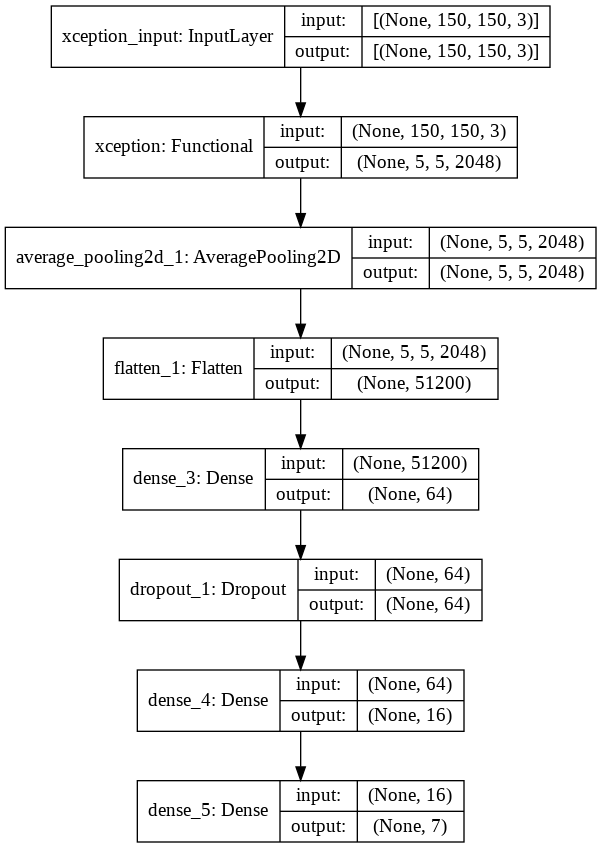

In [ ]:
base_model = 'Xception'
model = define_model(x_train, y_train, x_val, y_val, x_test, y_test, 
                     fine_tuning=True, base_model=base_model, regularizer=0.01,
                     dropout=0.3, pool_size = 1)

plot_model(model, to_file=f"{base_model}.png", show_shapes=True)